# Part 6.2 - Analysis Topic Model of Train Set
---
### Papers Past Topic Modeling
<br/>

Ben Faulks - bmf43@uclive.ac.nz

Xiandong Cai - xca24@uclive.ac.nz

Yujie Cui - ycu23@uclive.ac.nz

In [1]:
import sys, gc
sys.path.insert(0, '../utils')
from utils import filter_topics, plot_topics, plot_wordcloud
import pandas as pd
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 120)

from sklearn.preprocessing import MinMaxScaler
from wordcloud import WordCloud
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')
sns.axes_style("darkgrid")
%matplotlib inline
dpi=80

import datetime
print (datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2019-02-01 22:59:43


**For computing resource limitation, we did not train the full dataset, but trained a random sampling dataset (train set). In this part, we will use the topic modeling result from part 6.1 to analyze the train set making a general analysis.** 

**To evaluate and compare the distribution of topics, we use two basic metrics, in practice we use both to find interesting topics:**
1. The dominant topic counts. 

    Every document has a dominant topic represent the most portion of its contents. By summing the number of each dominant topic in a range of time, we see the variety and trend of each topic over time. It is easy to understand and fit for scatter plot, but in this way it ignores  non-dominant topics.

1. The average weight of topics over time.

    This metric is the average weight of a topic through all documents in a range of time, it avoid the issue above, reflect the topic variety and trend over time. However, it might give a frequent/normal topic (which has a small weight in each document) a high weight because the topic appears in large number of documents, when sum all weights of each topic and divid by total weight of all topics, this normal topic may get a high weight.
    

**To visualize the topics, we use all or part of below plots:**

1. word cloud to display topic words.

1. Scatter plot to dispaly the dominant tpics distribution over time.

1. Bar chart to display the dominant topics count over time.

1. Point plot to display the average topic weight over time.

## 1 Load dataframes

**Load the processed dataframes:**
* `topicKeys.txt`: topic words list
* `domTopic.csv`: document dominant topics dataframe
* `avgWeight.csv`: average topic weight dataframe

**Topics List:**

In [2]:
path = r'../models/train/topicKeys.txt'

df_topics = (pd.read_table(path, 
                           header=None, 
                           index_col=None, 
                           names = ['topic_', 'weight_', 'keywords_'],
                           encoding='utf8')
             .sort_values(by='topic_')
             .reset_index(drop=True))

topics_shape = df_topics.shape

In [3]:
print('Shape of dataframe:', topics_shape)
df_topics.head()

Shape of dataframe: (200, 3)


topic_  weight_  \
0       0  0.00161   
1       1  0.00908   
2       2  0.00116   
3       3  0.00893   
4       4  0.01761   

                                                                                                                 keywords_  
0  apply wanted good post work experience wellington position wages salary office experienced box required applications...  
1  killed police received people london persons hundred men explosion city women injured thousand number arrested wound...  
2  rooms price section bungalow deposit large modern home street garage kitchenette good sale post terms tram city view...  
3  meeting committee board motion chairman seconded moved thought matter present report carried messrs read resolution ...  
4  sydney south australia melbourne australian wales new_zealand received victoria queensland government federal adelai...

**Docmument - dominant topics dataframe:**

In [4]:
path = r'../models/train/domTopics.csv'

df_domtopic = pd.read_csv(path, 
                          header=None, 
                          index_col=None, 
                          names = ['id', 'region', 'year', 'topic', 'weight', 'keywords_'],
                          dtype={2:'str'},
                          encoding='utf8').sort_values(by='id').reset_index(drop=True)

# short keywords for easy plot
df_domtopic['keywords'] = df_domtopic['keywords_'].str.slice(0,60)+'...'
df_domtopic.drop("keywords_", axis=1, inplace=True)

In [5]:
print('Shape of dataframe:', df_domtopic.shape)
df_domtopic.sample(5)

Shape of dataframe: (3025602, 6)


id      region  year  topic    weight  \
2740006  28240810    Auckland  1891     87  0.489409   
964453   10849872     Waikato  1895     67  0.943274   
1783632  18085392  Wellington  1926    125  0.196622   
2184754  24208752    Taranaki  1911    168  0.425280   
1927975  19040972  Wellington  1925    193  0.371602   

                                                                keywords  
2740006  port arrived steamer cargo left captain vessel ship auckland...  
964453   gold mining mine reef claim company stone level ground feet ...  
1783632  street prices phone advertisements column motor good price c...  
2184754  good great present applause work people years made time chee...  
1927975  life love god heart day thy man world great thou men death l...

**Average topic weight dataframe:**

In [6]:
path = r'../models/train/avgWeight.csv'

# generate new column names
columns = [str(x) for x in list(range(topics_shape[0]))]
columns.insert(0, 'year')

df_avgweight = pd.read_csv(path, 
                           header=None, 
                           index_col=None, 
                           names = columns,
                           dtype={0:'str'},
                           encoding='utf8')

# melt for plot
df_avgweight = pd.melt(df_avgweight,
                       id_vars='year',
                       value_vars=list(df_avgweight.columns[1:]),
                       var_name='topic',
                       value_name='weight')
# change data type
df_avgweight.topic = df_avgweight.topic.astype(int)

# join
df_avgweight = (df_avgweight
                .merge(df_topics, left_on='topic', right_on='topic_')
                .drop('topic_', axis=1)
                .drop('weight_', axis=1)
                .sort_values(by=['year', 'topic'])
                .reset_index(drop=True))

# short keywords for easy plot
df_avgweight['keywords'] = df_avgweight['keywords_'].str.slice(0,60)+'...'
df_avgweight.drop("keywords_", axis=1, inplace=True)

df_topics.columns = ['topic', 'weight', 'keywords']

In [7]:
print('Shape of dataframe:', df_avgweight.shape)
df_avgweight.sample(5)

Shape of dataframe: (20800, 4)


year  topic    weight  \
18737  1935    137  0.004673   
11779  1897    179  0.005085   
4861   1863     61  0.001040   
5911   1868    111  0.004766   
977    1843    177  0.008472   

                                                              keywords  
18737  commission department report made evidence government servic...  
11779  road board council county chairman meeting bridge work roads...  
4861   pianos piano english instruments watch organs music price wa...  
5911   john james william george thomas henry charles robert smith ...  
977    apply freight passage steam passengers new_zealand company w...

## 2 The Most Distinct Documents

**First of all, check the document with the highest weight topic through all documents, which means the document contains the fewest topics, easy to check the topic by eyes. Most this kind of documents are oversimplified, but it is a simple way to check topics. Here we print the top one of them.**

In [8]:
df_domtopic.sort_values(by='weight', ascending=False).head(3)

id      region  year  topic    weight  \
1699632  17545313  Wellington  1930     41  0.998863   
1663783  17237147  Wellington  1939     41  0.998814   
2003827  19646327  Wellington  1932     41  0.998366   

                                                                keywords  
1699632  auckland wellington left due london january december lyttelt...  
1663783  auckland wellington left due london january december lyttelt...  
2003827  auckland wellington left due london january december lyttelt...

In [9]:
id_ = df_domtopic.sort_values(by='weight', ascending=False).iloc[0]['id']
id_

17545313

In [10]:
%%bash -s $id_

echo 'Print 1500 characters of document id: '$1
grep -nw ../data/dataset/sample/train/train.csv -e $1 | cut -c1-2000

Print 1500 characters of document id: 17545313
1699633:17545313	SHIPPING NEWS	"SHIPPING NEWSHIGH WATER. To-day: 9.32 a.m.; 9.49 p.m. To-morrow: 10.18 a.m.; 10.30 p.m. ARRIVALS. FRIDAY, 4th AritlL. WAKAKURA, mine-sweeper (3.20 p.m.), 290 toils, Kdwards, from Picton. OREPUKI, s.s. (5.15 p.m.), 575 tons, Pearson, from Lyttelton. KOMATA. s.s. (10.40 p.m.). 2115 tons, Whyborn, from Westport. SATURDAY, Sth APRIL. TAMAHINE, s.s. (1.55 a.m.), 1959 tons, Kane, ' from Picton. PROGRESS, s.s. (4.15 a.m.), 353 tons, Hay, from Timaru. ARAHURA, s.s. (5.30 a.m.), 1590 tons, Wildman, from Nelson. MAORI, s.s. (0.55 a.m.), 3458- tons, Irwin, from Lyttelton. CORINTHIC, s.s. (7.15 a.m.), 12,3-13 tons. Freeman, from Lyttelton. NIKAU, s.s. (7.20 a.m.), 248 tons, M'Millan, from Mapua. KOHI, aux. scow (S.lO a.m.), 125 tons, Coldic, from Taliaka. DEPARTURES. FRIDAY, 4th APRIL. TAMAHINE, s.s. (3 p.m.), 1959 tons, Kane, for Picton. JOHN, s.s. (3.15 p.m.), 312 tons. Holm, for Dunedin. KAHIKA, s.s. (5.15 p.m.), 117

## 3 General Distribution of Topics

### 3.1 Word Cloud

**Since MALLET outputs topic keywords without weight of each keywords, so we will add sequential weight (like arithmetic progression) for each keywords, which means the weight of each keywords is not accurate, but for word cloud it is acceptable. Below plot shows the highest weight 20 topics in topics list.**

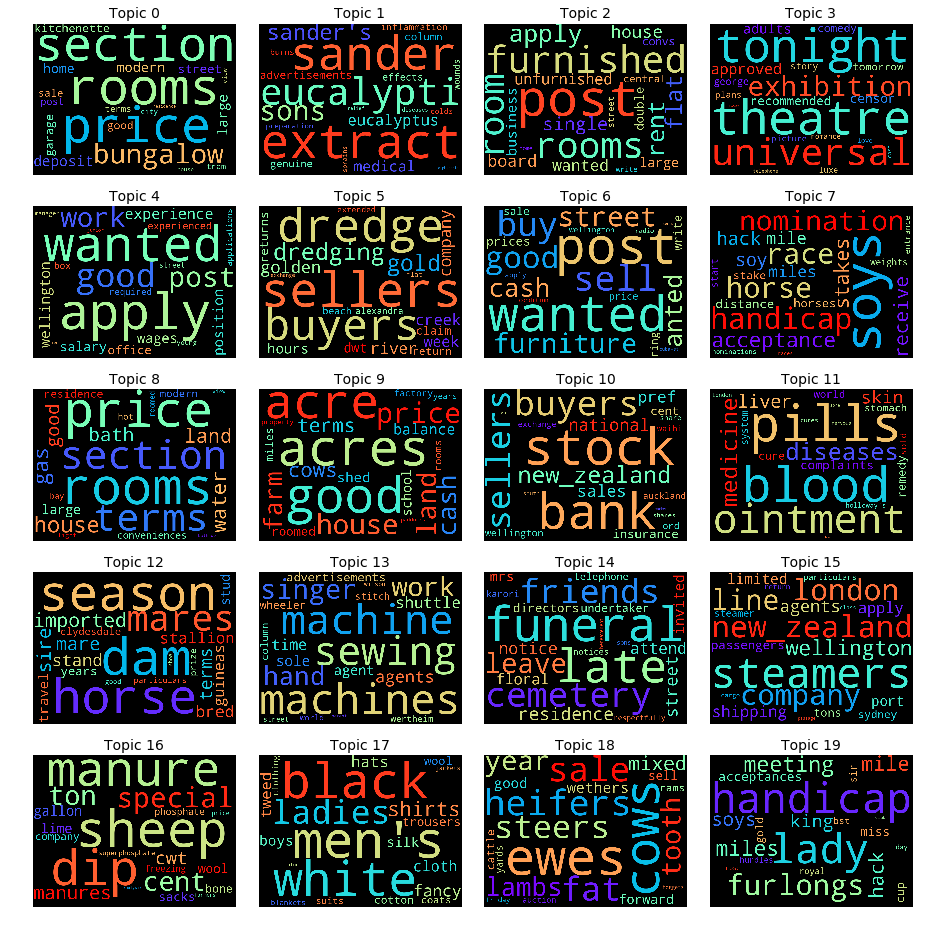

In [11]:
df_plt = df_topics.copy(deep=True).sort_values(by='weight')

plot_wordcloud(df_plt, 20, 20, 4)

### 3.2 Documents Distribution

**Before checking the topic distribution, we should take a look at the documents distribution.**

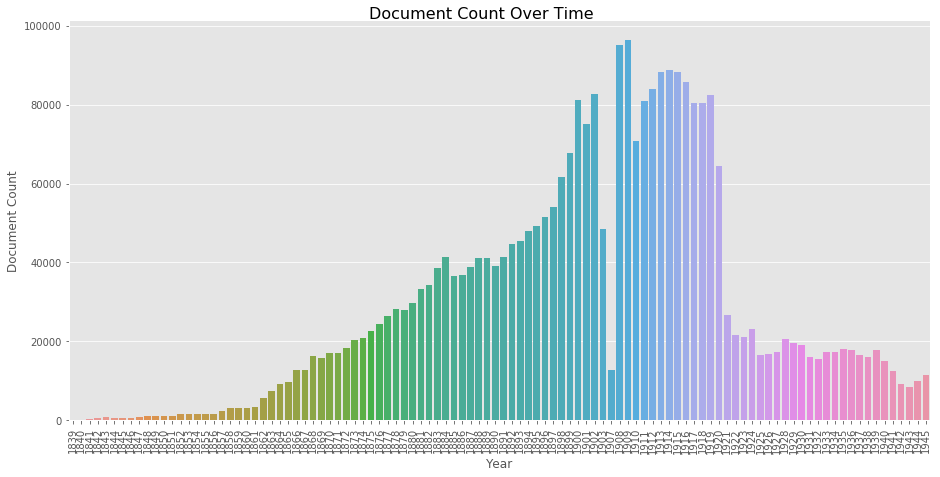

In [12]:
g = sns.catplot(x="year",
                kind='count', height=6.5, aspect=2, 
                dodge=False, legend=False, 
                data=df_domtopic)
g.fig.suptitle("Document Count Over Time", fontsize=16)
g.fig.subplots_adjust(top=0.95)
g.set(xlabel='Year', ylabel='Document Count')        
g.set_xticklabels(rotation=90, step=1)

### 3.3 Dominant Topics Distribution

**We plot all the dominant topics to glimpse the distribution in general, each point represents a document in a certainn year with certain dominant topic weight, the color changes over time.**

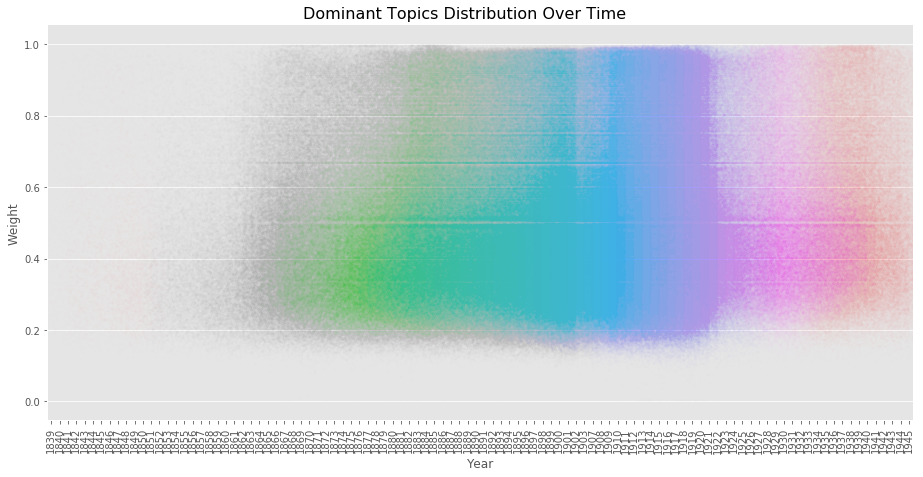

In [13]:
g = sns.catplot(x="year", y='weight',
                kind='strip', height=6.5, aspect=2, 
                jitter=2, dodge=False, 
                s=3, alpha=0.004,
                legend=False,
                data=df_domtopic)

g.fig.subplots_adjust(top=0.94)
g.fig.suptitle("Dominant Topics Distribution Over Time", fontsize=16)
g.set(xlabel='Year', ylabel='Weight')
g.set_xticklabels(rotation=90)

### 3.4 Annual Average Weight Distribution

**We plot all the annual average weight to see the general distribution:**

In [14]:
df_plt = df_avgweight[['year', 'topic', 'weight']]

df_plt = pd.pivot_table(data=df_plt,
                        index='topic',
                        values='weight',
                        columns='year')
scaler = MinMaxScaler()
df_plt_scaled = pd.DataFrame(scaler.fit_transform(df_plt),columns = df_plt.columns)
df_plt.head()

year       1839      1840      1841      1842      1843      1844      1845  \
topic                                                                         
0      0.005073  0.000449  0.000049  0.000042  0.001198  0.000166  0.000084   
1      0.000030  0.000176  0.000946  0.002522  0.002282  0.003175  0.004854   
2      0.000004  0.000014  0.000016  0.000177  0.000014  0.000013  0.000015   
3      0.000029  0.007261  0.001829  0.007565  0.004898  0.005631  0.005014   
4      0.021866  0.009739  0.005646  0.004207  0.013800  0.006902  0.007129   

year       1846      1847      1848      1849      1850      1851      1852  \
topic                                                                         
0      0.000306  0.000163  0.000154  0.000379  0.000542  0.000173  0.000079   
1      0.001680  0.002620  0.006248  0.004410  0.002973  0.003341  0.002469   
2      0.000219  0.000022  0.000031  0.000163  0.000008  0.000014  0.000022   
3      0.003953  0.003612  0.002227  0.004002  0.002779  0.006103  0.007070   
4      0.005414  0.005956  0.004573  0.003708  0.003348  0.004921  0.005560   

year       1853      1854      1855      1856      1857      1858      1859  \
topic                                                                         
0      0.000174  0.000365  0.000244  0.000093  0.000183  0.000219  0.000143   
1      0.002326  0.002286  0.003000  0.002299  0.003754  0.004269  0.002253   
2      0.000051  0.000052  0.000057  0.000015  0.000029  0.000013  0.000015   
3      0.008712  0.008281  0.008649  0.008198  0.006838  0.007289  0.007777   
4      0.004398  0.002600  0.002834  0.002474  0.003503  0.004589  0.004050   

year       1860      1861      1862      1863      1864      1865      1866  \
topic                                                                         
0      0.000110  0.000402  0.000366  0.000179  0.000145  0.000285  0.000223   
1      0.002648  0.002972  0.001616  0.002984  0.002931  0.002033  0.002255   
2      0.000039  0.000093  0.000049  0.000071  0.000037  0.000028  0.000036   
3      0.006157  0.005297  0.006575  0.006053  0.006169  0.005787  0.006510   
4      0.003060  0.003429  0.006373  0.005637  0.004923  0.003643  0.005086   

year       1867      1868      1869      1870      1871      1872      1873  \
topic                                                                         
0      0.000125  0.000099  0.000175  0.000138  0.000241  0.000129  0.000203   
1      0.002142  0.002880  0.002136  0.002383  0.003545  0.002705  0.001545   
2      0.000044  0.000072  0.000048  0.000045  0.000047  0.000050  0.000038   
3      0.007023  0.008718  0.008907  0.008308  0.008103  0.008059  0.008842   
4      0.003633  0.004690  0.004564  0.004446  0.004223  0.005611  0.006421   

year       1874      1875      1876      1877      1878      1879      1880  \
topic                                                                         
0      0.000241  0.000196  0.000206  0.000321  0.000264  0.000255  0.000226   
1      0.002351  0.001945  0.002270  0.002702  0.002682  0.003326  0.003342   
2      0.000059  0.000064  0.000069  0.000066  0.000083  0.000081  0.000078   
3      0.008050  0.009491  0.009023  0.009641  0.008998  0.009400  0.008205   
4      0.005423  0.005352  0.008088  0.009412  0.009120  0.013363  0.013060   

year       1881      1882      1883      1884      1885      1886      1887  \
topic                                                                         
0      0.000148  0.000162  0.000192  0.000172  0.000210  0.000202  0.000178   
1      0.004552  0.004462  0.006118  0.004630  0.003619  0.005492  0.006798   
2      0.000074  0.000081  0.000069  0.000065  0.000089  0.000064  0.000080   
3      0.008849  0.007786  0.008117  0.008203  0.007898  0.008992  0.008208   
4      0.011396  0.011713  0.015503  0.014684  0.015542  0.015401  0.015322   

year       1888      1889      1890      1891      1892      1893      1894  \
topic                                      

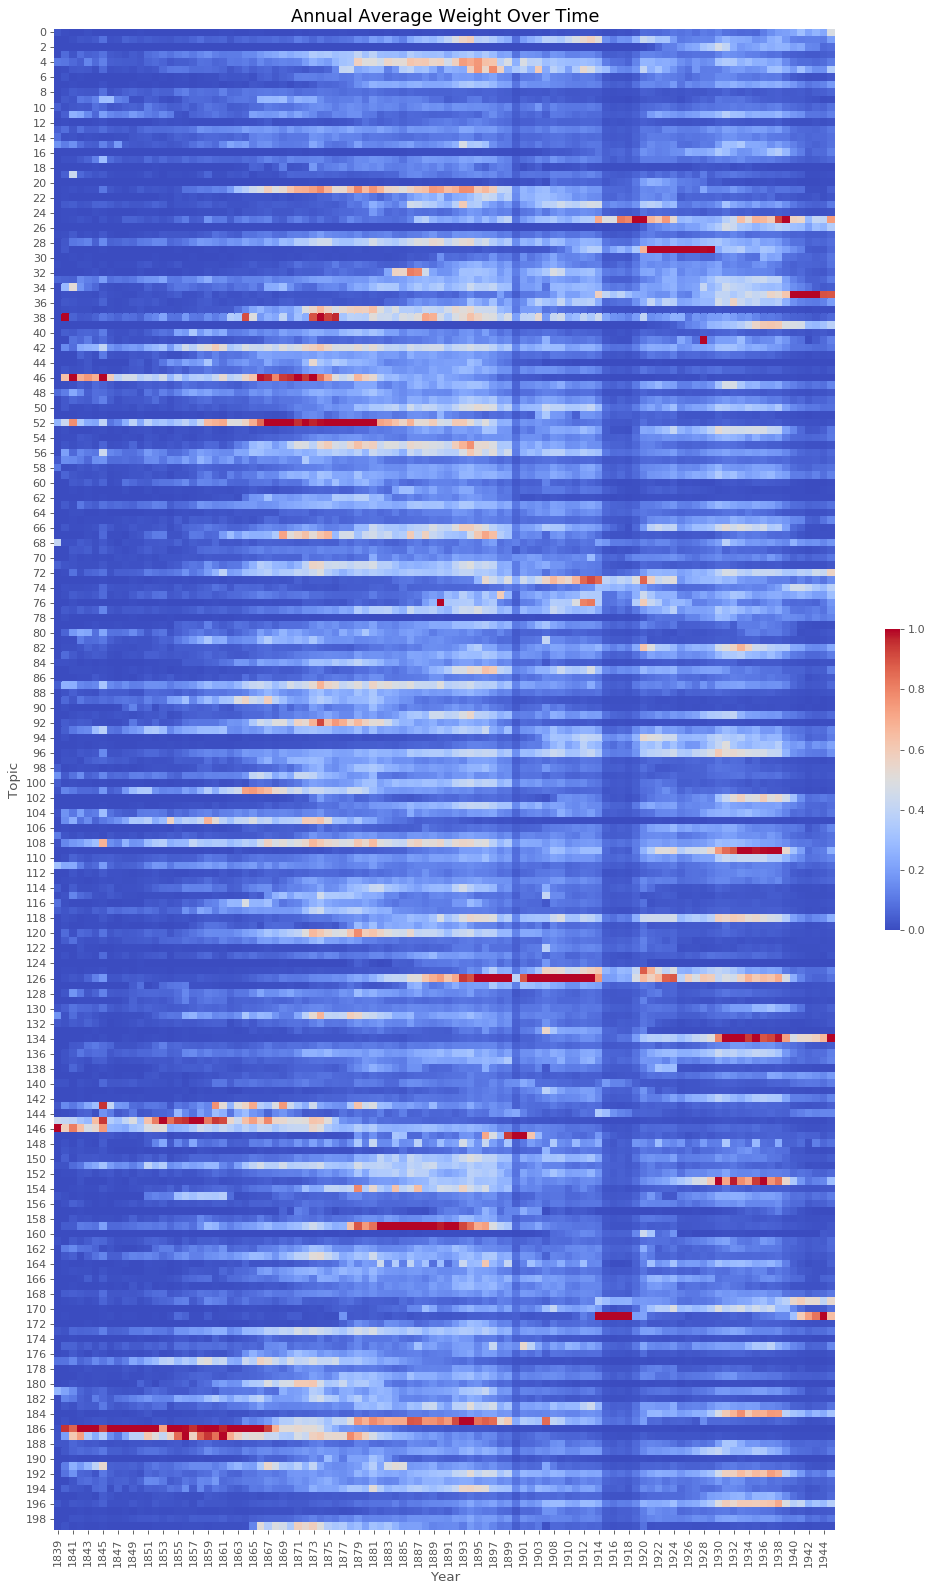

In [15]:
fig, ax = plt.subplots(figsize=(13, 20), dpi=80)

sns.heatmap(df_plt_scaled,
            cmap='coolwarm',
            cbar=True,
            cbar_kws={"shrink": .2},
            annot=False,
            square=True,
            ax=ax
            )

plt.xlabel('Year')
plt.ylabel('Topic')
plt.title("Annual Average Weight Over Time", fontdict=dict(size=16))
plt.xticks(rotation='90')
plt.tight_layout()
plt.show()

### 3.5 Annual Average Weight of Each Topic

**Plot all topics average weight to check trend of each topic.**

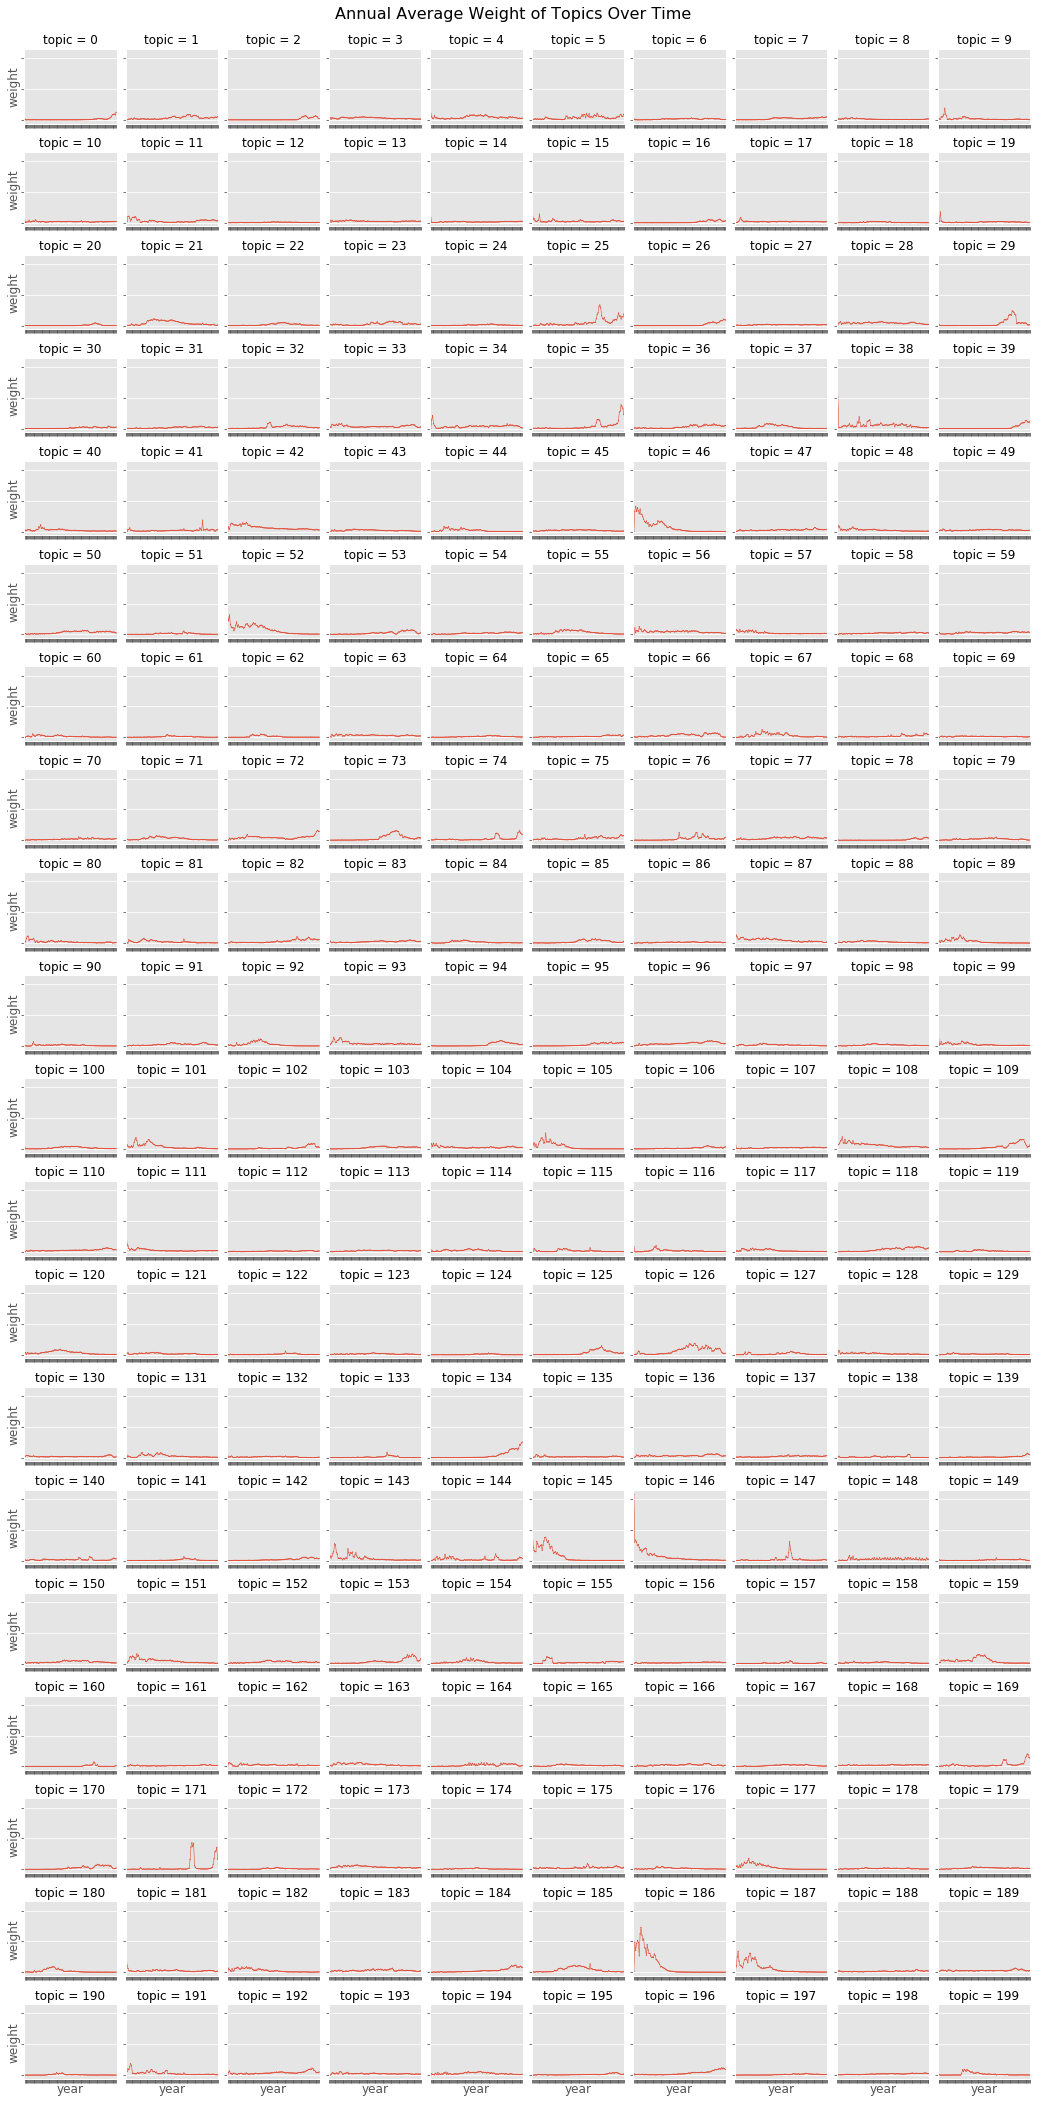

In [16]:
g = sns.catplot(x="year", y='weight',  col='topic', col_wrap=10, 
                kind='point', height=1.5, aspect=1, dodge=False, s=0.2, legend=False, 
                markers='.', scale=0.2,
                data=df_avgweight)
g.fig.suptitle("Annual Average Weight of Topics Over Time", fontsize=16)
g.set_xticklabels(visible=False)
g.set_yticklabels(visible=False)
g.fig.subplots_adjust(top=0.96, hspace=0.4, wspace=0.1)

## 4 The First 10 Topics

**Before we try to find topics with specific features, we plot the first 10 topics to see the situation:**

**Generate dominant topics dataframe for plot:**

In [17]:
topic_list = list(range(10))

print('List of topics to plot:', topic_list)

df_plt_dom = filter_topics(df_domtopic, topic_list)
df_plt_avg = filter_topics(df_avgweight, topic_list)

print('Shape of df_plt_dom:', df_plt_dom.shape)
print('Shape of df_plt_avg:', df_plt_avg.shape)

df_col_order = filter_topics(df_topics, topic_list).set_index('topic')
df_col_order = df_col_order.loc[topic_list]
col_order = df_col_order.keywords.str.slice(0,60)+'...'
df_col_order.head(10)

List of topics to plot: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Shape of df_plt_dom: (160186, 6)
Shape of df_plt_avg: (1040, 4)


weight  \
topic            
0      0.00161   
1      0.00908   
2      0.00116   
3      0.00893   
4      0.01761   
5      0.00908   
6      0.00360   
7      0.00325   
8      0.00397   
9      0.00332   

                                                                                                                      keywords  
topic                                                                                                                           
0      apply wanted good post work experience wellington position wages salary office experienced box required applications...  
1      killed police received people london persons hundred men explosion city women injured thousand number arrested wound...  
2      rooms price section bungalow deposit large modern home street garage kitchenette good sale post terms tram city view...  
3      meeting committee board motion chairman seconded moved thought matter present report carried messrs read resolution ...  
4      sydney south australia melbourne australian wales new_zealand received victoria queensland government federal adelai...  
5      chinese china japanese japan russia russian turkish troops british turkey received government war constantinople lon...  
6      yds prize yards race handicap sports entrance match rifle points events shooting trophy club competition won prizes ...  
7      handicap lady furlongs meeting miles mile hack soys king acceptances miss cup gold sir bst royal hurdles day rose club   
8      reward lost ost white found dog finder apply notice black branded person bay return pound returning office gold satu...  
9      duty customs duties tariff sugar goods free cent revenue tobacco paid amount beer stamp colony consumption articles ...

**Dominant topics distribution by year:**

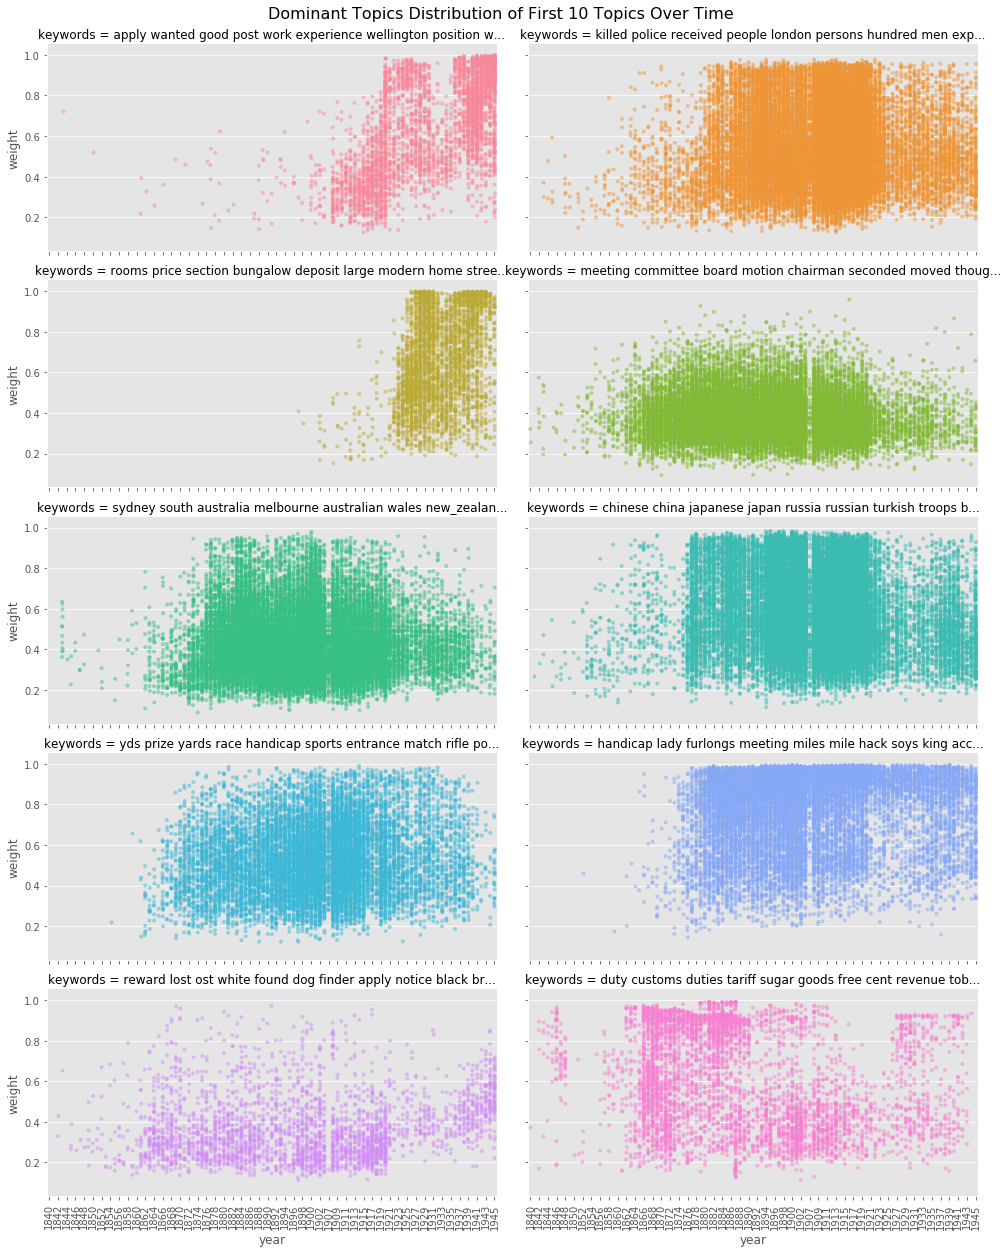

In [18]:
plot_topics(df_plt_dom, 
            'scatter', 
            col_order=col_order,
            adjust_top=0.95,
            title='First 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

**Dominant topics count by year:**

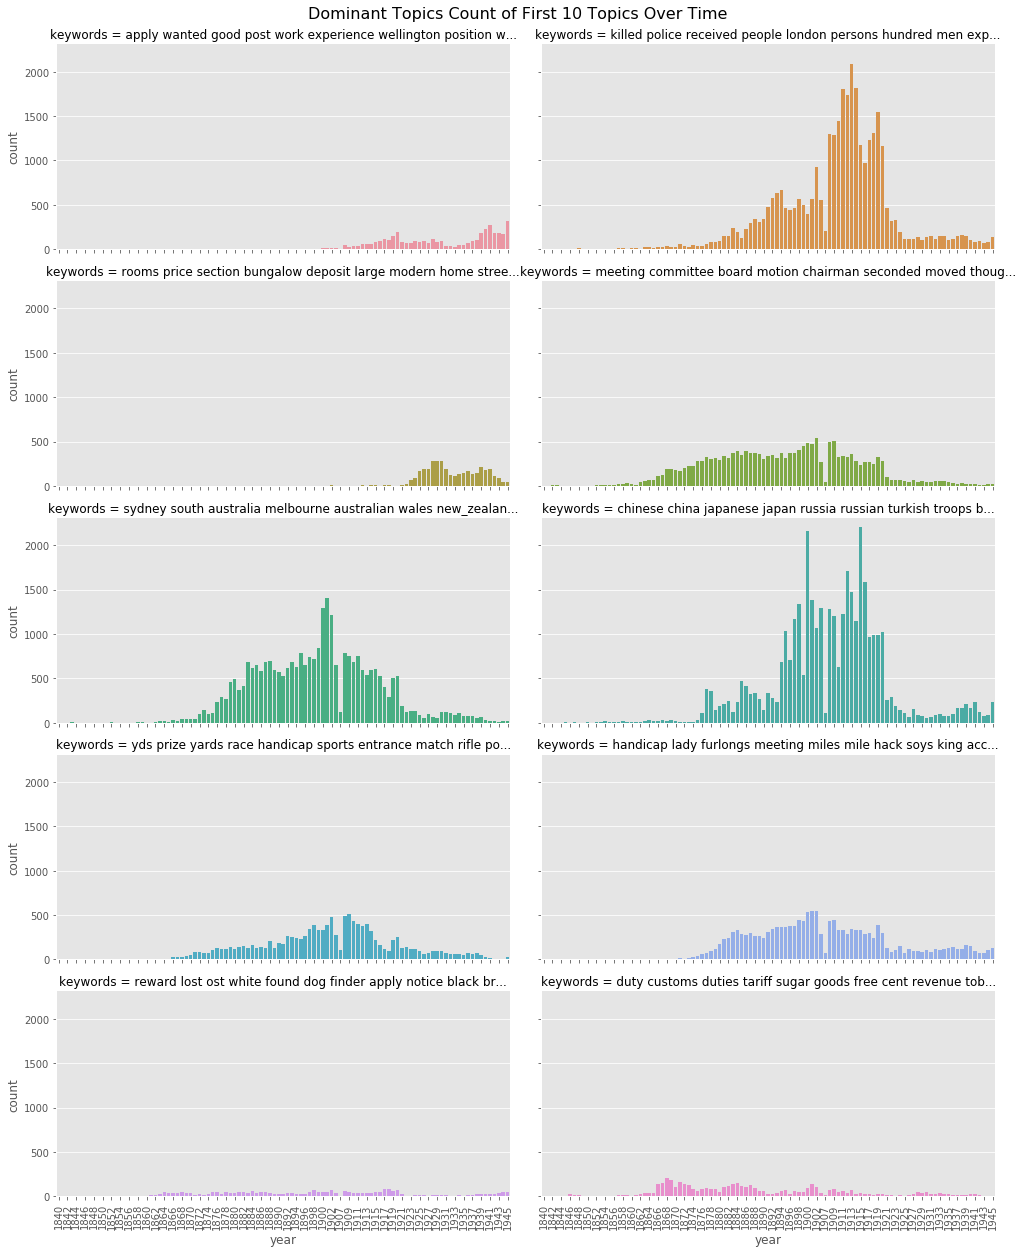

In [19]:
plot_topics(df_plt_dom, 
            'bar', 
            col_order=col_order,
            adjust_top=0.95,
            title='First 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

**Average topic weight by year:**

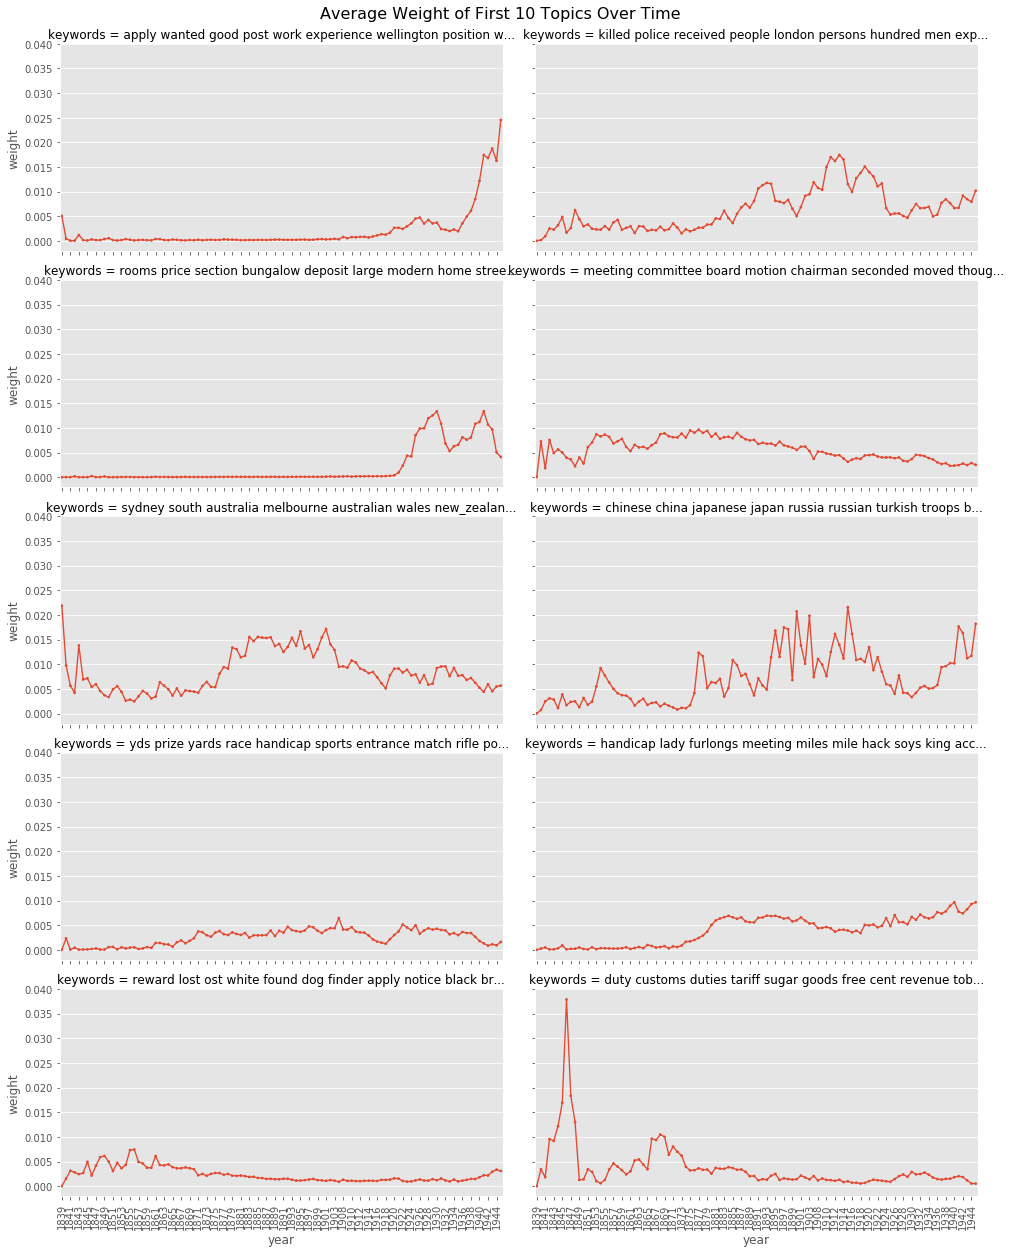

In [20]:
plot_topics(df_plt_avg, 
            'point', 
            col_order=col_order,
            adjust_top=0.95,
            title='First 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

## 5 The Most Variant Topics

**By caculating the standard deviation of average weight of each topic, we get the most variant topics. Some weights of topic may vary following the overall trends, it's better to remove the effect of overall trend for more accurate evaluation. Here we ignore the effect of overall trends.**

In [21]:
topic_list = list(df_avgweight.groupby('topic')['weight']
                  .std().sort_values(ascending=False).index[:10])

print('List of topics to plot:', topic_list)

df_plt_dom = filter_topics(df_domtopic, topic_list)
df_plt_avg = filter_topics(df_avgweight, topic_list)

print('Shape of df_plt_dom:', df_plt_dom.shape)
print('Shape of df_plt_avg:', df_plt_avg.shape)

df_col_order = filter_topics(df_topics, topic_list).set_index('topic')
df_col_order = df_col_order.loc[topic_list]
col_order = df_col_order.keywords.str.slice(0,60)+'...'
df_col_order.head(10)

List of topics to plot: [186, 146, 145, 46, 171, 187, 35, 52, 25, 134]
Shape of df_plt_dom: (247192, 6)
Shape of df_plt_avg: (1040, 4)


weight  \
topic            
186    0.00390   
146    0.00981   
145    0.00537   
46     0.00382   
171    0.00752   
187    0.00756   
35     0.00953   
52     0.01537   
25     0.01345   
134    0.00987   

                                                                                                                      keywords  
topic                                                                                                                           
186      cases casks ditto boxes sale case oil brandy bags ale tea sugar foot candles cwt tons iron white tobacco undersigned   
146    colony country new_zealand great large land population present time years people means good colonies made industry n...  
145    government provincial province council colony general superintendent governor public assembly colonial honor new_zea...  
46     tons schooner cases barque melbourne agents passengers agent case port bags cargo early cutter sailed wellington lyt...  
171    german enemy germans front french london british fighting troops attack captured received russian artillery line sta...  
187    sale acres land apply house property particulars sections section town terms good situated road farm street freehold...  
35     air british naval german ships navy fleet london sea submarine vessels admiral war admiralty received flying ship to...  
52     business public notice orders begs attention stock street goods general premises inform prices customers advertiseme...  
25     german germany received peace war berlin government france london paris french states russia italy correspondent bri...  
134    new_zealand government work made scheme system industry national dominion control conditions country present time pu...

**Dominant topics distribution by year:**

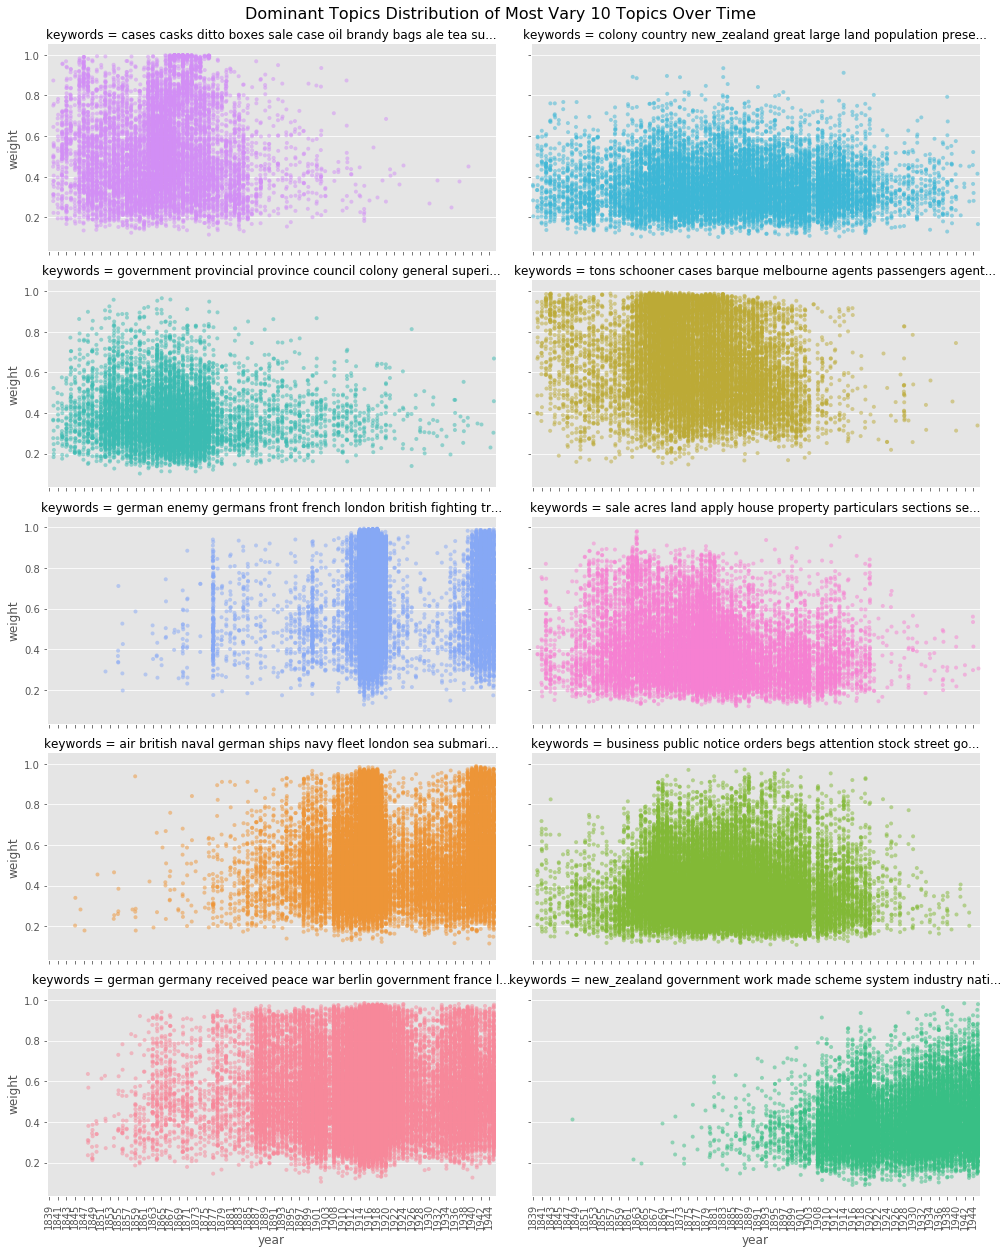

In [22]:
plot_topics(df_plt_dom, 
            'scatter', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Vary 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

**Dominant topics count by year:**

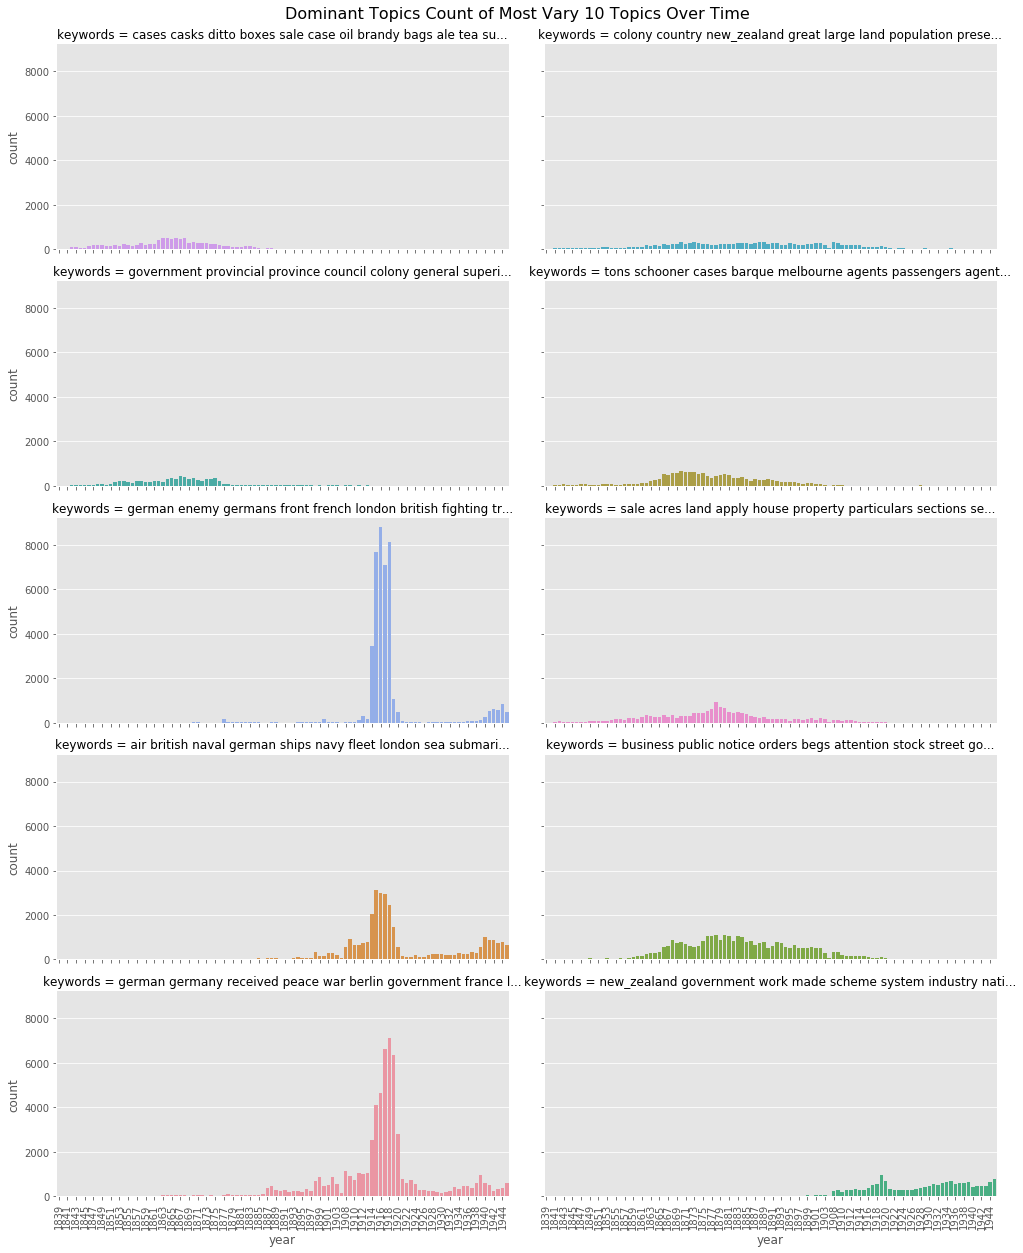

In [23]:
plot_topics(df_plt_dom, 
            'bar', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Vary 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

**Average topic weight by year:**

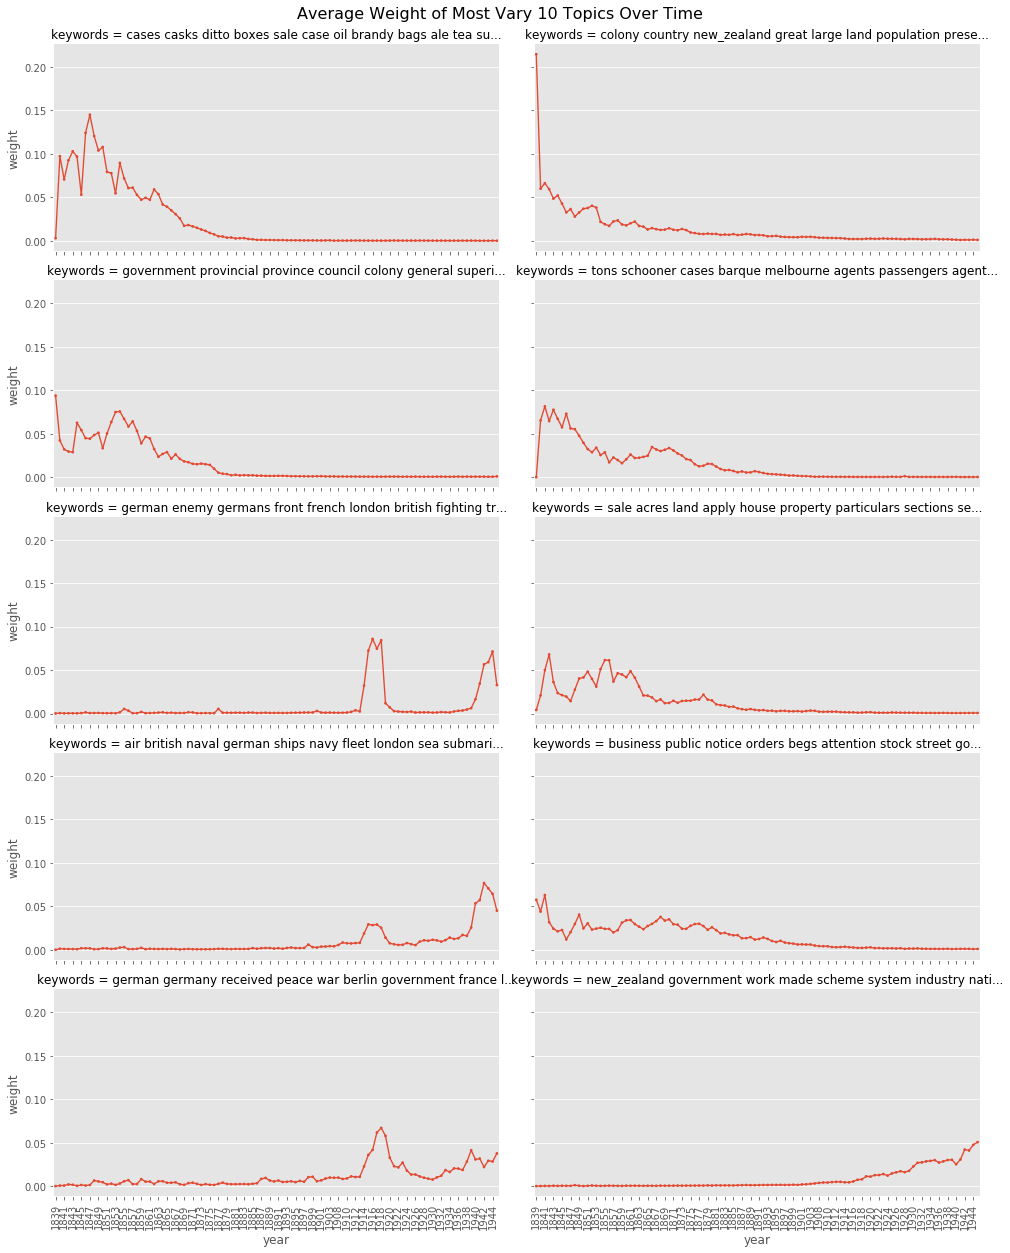

In [24]:
plot_topics(df_plt_avg, 
            'point', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Vary 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

## 6 The Most Significant Topics

**Variance dose not consider the document number, if a topic has high variance but the support documents are few, the topic is not significant. To find significant, we use the figure that dominant topic count multiply the average weight of the topic, this figure considers both the number of support document and the average weight of topic. This way magnifies the topics that are dominant topics of documents, we take it as significant topics.**

In [25]:
df_domtopic_count = (df_domtopic.groupby(['year', 'topic'])
                     .size().reset_index(name='count')
                     .sort_values(['year', 'topic']))
df_domtopic_count.columns = ['year_', 'topic_', 'count']

df_signif = df_avgweight.copy(deep=True)

df_signif = (df_signif
             .merge(df_domtopic_count, left_on=['year', 'topic'], right_on=['year_', 'topic_'], how='outer')
             .sort_values(by=['year', 'topic'])
             .drop(columns=['keywords', 'year_', 'topic_'])
             .reset_index(drop=True)
             .fillna(0))

df_signif['value'] = df_signif['weight'] * df_signif['count']

topic_list = list(df_signif.groupby('topic')['value'].std().sort_values(ascending=False).index[:10])

print('List of topics to plot:', topic_list)

df_plt_dom = filter_topics(df_domtopic, topic_list)
df_plt_avg = filter_topics(df_avgweight, topic_list)

print('Shape of df_plt_dom:', df_plt_dom.shape)
print('Shape of df_plt_avg:', df_plt_avg.shape)

df_col_order = filter_topics(df_topics, topic_list).set_index('topic')
df_col_order = df_col_order.loc[topic_list]
col_order = df_col_order.keywords.str.slice(0,60)+'...'
df_col_order.head(10)

List of topics to plot: [171, 25, 147, 73, 35, 125, 126, 29, 159, 76]
Shape of df_plt_dom: (371809, 6)
Shape of df_plt_avg: (1040, 4)


weight  \
topic            
171    0.00752   
25     0.01345   
147    0.00679   
73     0.01214   
35     0.00953   
125    0.01469   
126    0.03778   
29     0.00615   
159    0.00787   
76     0.00782   

                                                                                                                      keywords  
topic                                                                                                                           
171    german enemy germans front french london british fighting troops attack captured received russian artillery line sta...  
25     german germany received peace war berlin government france london paris french states russia italy correspondent bri...  
147    south africa boers british general war transvaal boer london lord received african cape capetown troops contingent p...  
73     cough column advertisements remedy colds cold cure advt bottle coughs throat great woods nazol chemists lung pepperm...  
35     air british naval german ships navy fleet london sea submarine vessels admiral war admiralty received flying ship to...  
125    street prices phone advertisements column motor good price cycle stock call buy quality work telephone box free cash...  
126    association press telegraph received copyright london united electric cable sydney april march news australian octob...  
29     theatre picture pictures story programme film to-night drama comedy love star shown girl life great feature supporti...  
159    london government french british foreign sir news england lord paris received english france general great prince ma...  
76     strike union men miners coal labour work workers association federation conference labor strikers wages received uni...

**Dominant topics distribution by year:**

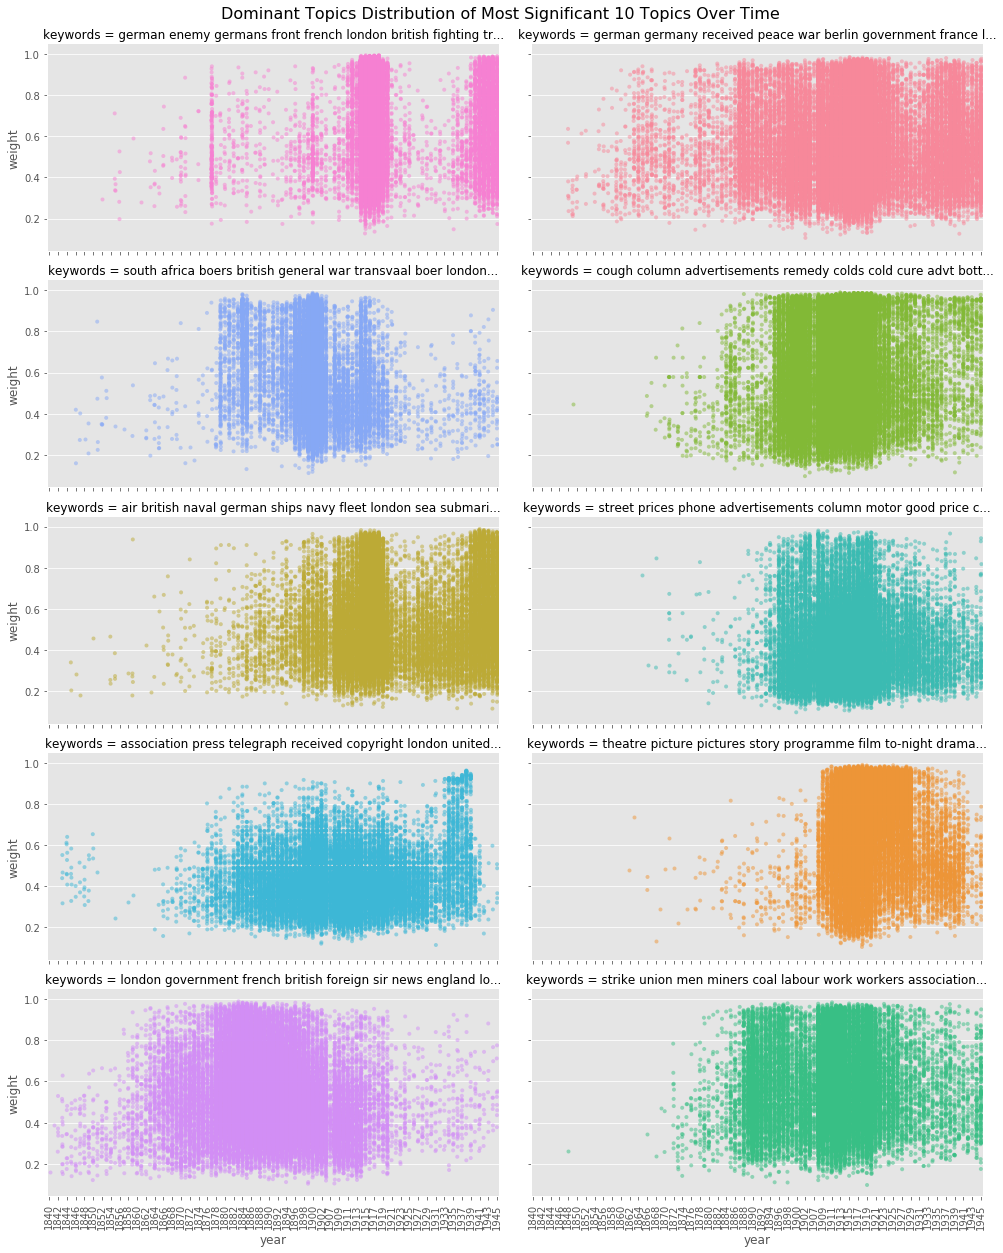

In [26]:
plot_topics(df_plt_dom, 
            'scatter', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

**Dominant topics count by year:**

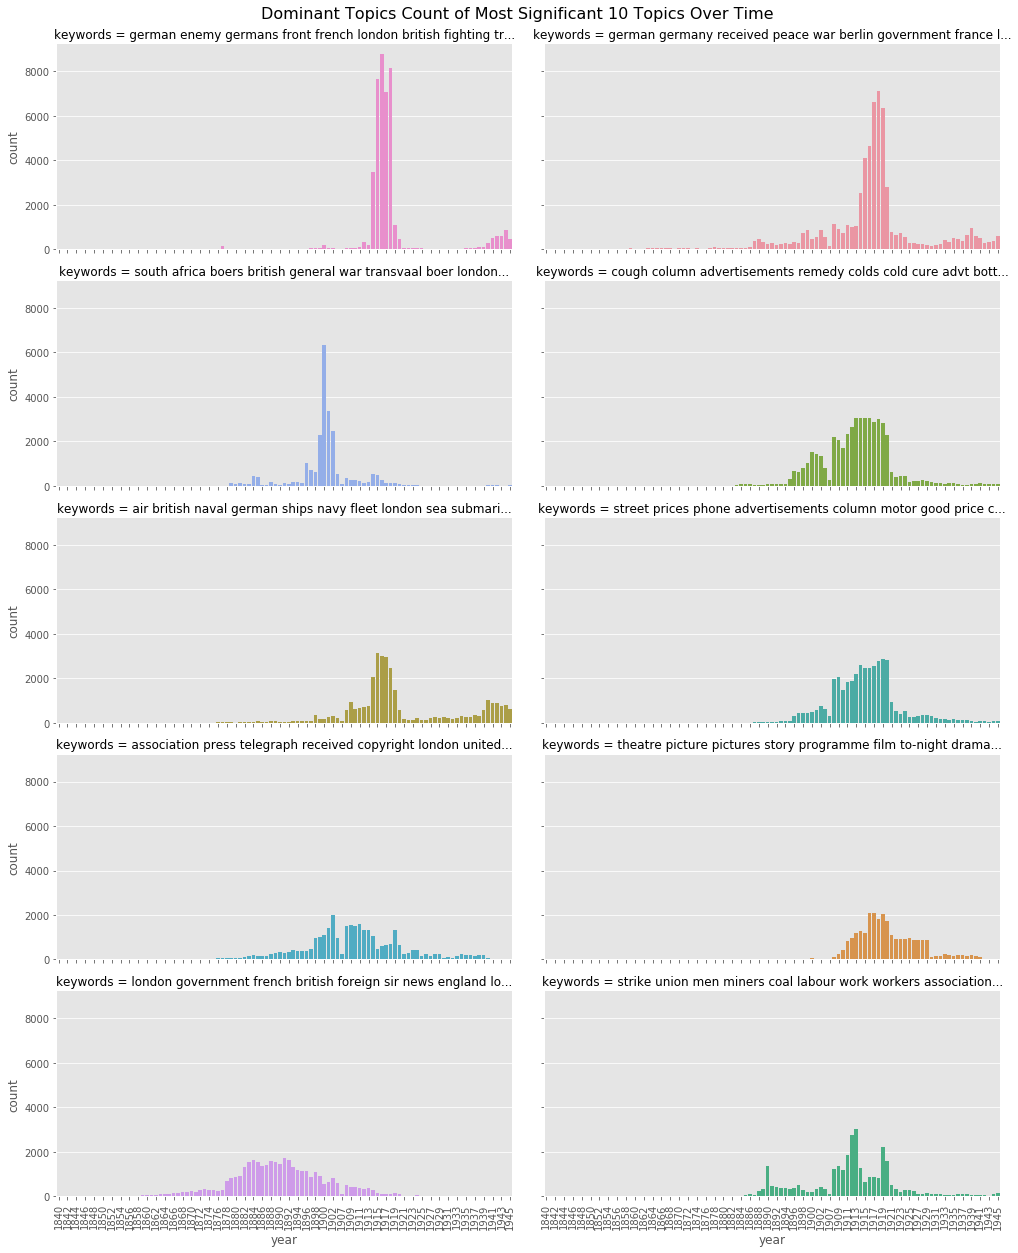

In [27]:
plot_topics(df_plt_dom, 
            'bar', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

**Average topic weight by year:**

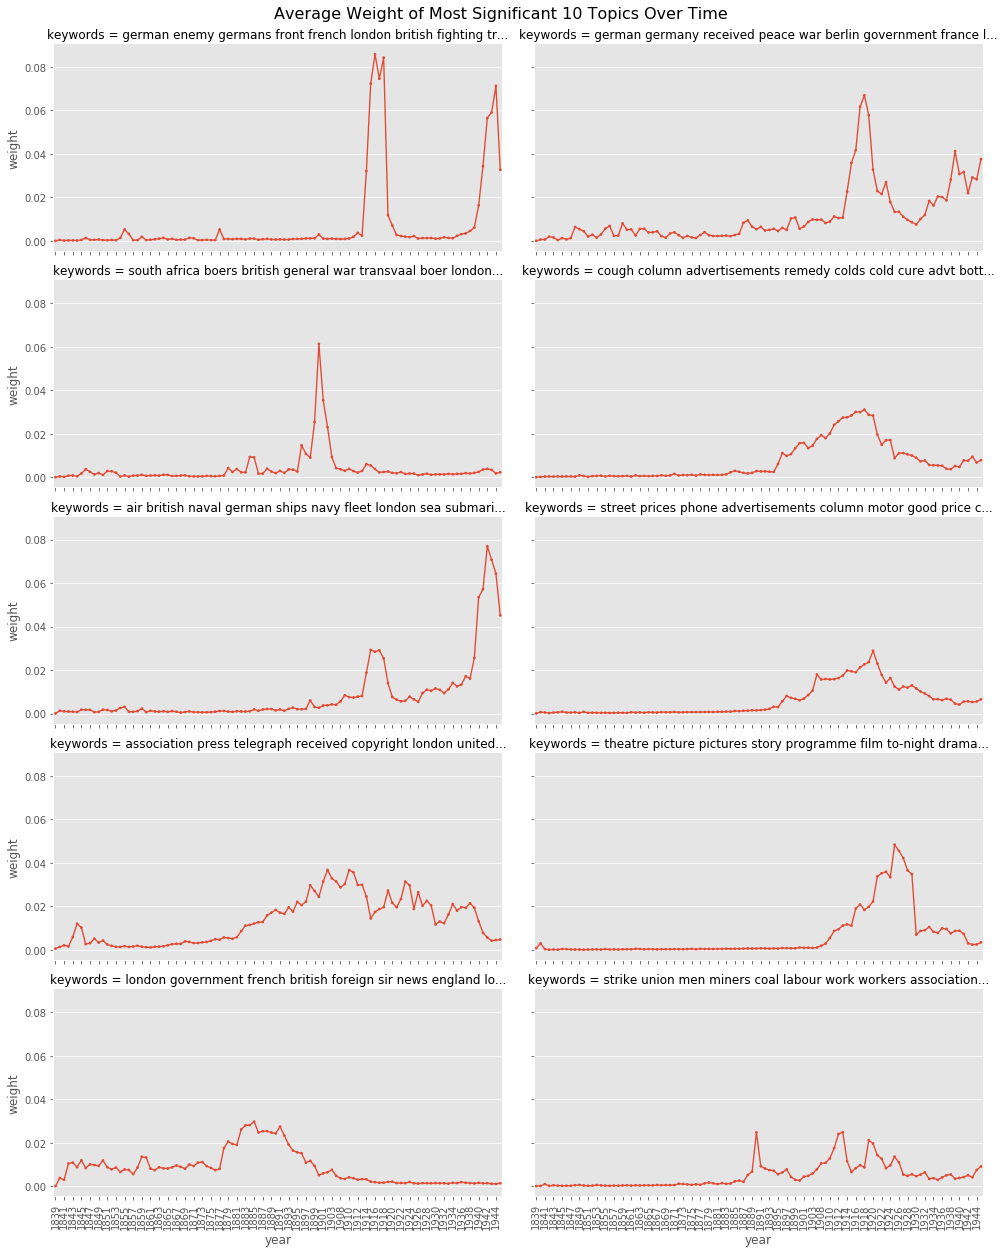

In [28]:
plot_topics(df_plt_avg, 
            'point', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

---

In [29]:
gc.collect()

240